# 1. Collect Academic Papers Information to Excel

## 1.1Collect Academic Papers Information and Save to json File

Install the Findpaper library


In [ ]:
!pip install findpapers
!pip show findpapers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.4.0
    Uninstalling lxml-5.4.0:
      Successfully uninstalled lxml-5.4.0
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
  Attempting uninstall: typer
    Found existing installation: typer 0.16.0
    Uninstalling typer-0.16.0:
      Successfully uninstalled typer-0.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

Check the Findpaper Version

In [ ]:
!findpapers version

findpapers 0.6.7


Directory path on Google drive

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

directory_path = '/content/drive/MyDrive/DL' #@param {type:"string"}
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Set API Keys in Environment Variables (here's your provided keys)
os.environ["SCOPUS_API_KEY"] = "7d18ea0a338c85deda997ada06dfa686"

#  Retrieve them when needed (for your program use)
SCOPUS_TOKEN = os.getenv("SCOPUS_API_KEY")

# Confirm they are set (optional — for testing)
print("Scopus Token:", SCOPUS_TOKEN)

Mounted at /content/drive
Scopus Token: 7d18ea0a338c85deda997ada06dfa686


Set the Parameters for Findpaper (If you want to search Scopus and IEEE, you need to enter the API key.)

In [ ]:
#QUERY = "[Virtual Reality] OR [Augmented Reality] OR ([Extended Reality] OR [Mixed Reality])"  #@param {type:"string"}
QUERY = '([Virtual Reality] OR [Augmented Reality] OR [Extended Reality] OR [Mixed Reality]) AND ([Therapy] OR [Treatment] OR [Intervention] OR [Rehabilitation] OR [Outcome]) AND ([Mental] OR [Psychological] OR [Emotional] OR [Addiction] OR [Alcohol] OR [Exposure] OR [Behavior] OR [Disorder]) AND NOT [Physical]'
folder_name = "search_rlhf_all"  #@param {type:"string"}

FOLDER = f'{directory_path}/{folder_name}.json'

NUM = 1000  # @param {type:"slider", min:10, max:1000, step:1}

SINCE = '2013-01-01'  #@param {type:"date"}
UNTIL = '2025-05-01'  #@param {type:"date"}

#@markdown Select Journals:

pubmed = True  #@param {type:"boolean"}
arxiv = True #@param {type:"boolean"}
scopus = True #@param {type:"boolean"}

selected_databases = []

if pubmed:
    selected_databases.append("pubmed")
if arxiv:
    selected_databases.append("arxiv")
if scopus:
    selected_databases.append("scopus")

DATABASES = ",".join(selected_databases)

selected_publication_types = ["journal"]

PUBLICATION_TYPE = ",".join(selected_publication_types)


Execute the Findpaper command

In [ ]:
#Run findpapers CLI command with tokens for Scopus and IEEE
!findpapers search {FOLDER} --query "{QUERY}" --limit-db {NUM} --since {SINCE} --until {UNTIL} --databases {DATABASES} --token-scopus {SCOPUS_TOKEN} --token-ieee {IEEE_TOKEN}


Streaming output truncated to the last 5000 lines.
2025-06-08 10:50:23,021 INFO: (291/2079) Enriching paper: Healthcare Interventions for Children Using Nonimmersive Virtual Reality: A Mixed Methods Systematic Review
2025-06-08 10:50:25,569 INFO: (292/2079) Enriching paper: A virtual reality environment for supporting mental wellbeing of students on remote clinical placement: A multi-methods evaluation.
2025-06-08 10:50:25,569 INFO: (293/2079) Enriching paper: Exploring the perceptions of former ICU patients and clinical staff on barriers and facilitators to the implementation of virtual reality exposure therapy: A qualitative study.
2025-06-08 10:50:25,569 INFO: (294/2079) Enriching paper: Virtual Reality for Postoperative Pain Management: A Review of Current Evidence
2025-06-08 10:50:29,483 INFO: (295/2079) Enriching paper: Effects of artificial intelligence and virtual reality interventions in art therapy among older people with mild cognitive impairment
2025-06-08 10:50:31,687 INFO

## 1.2 1.2 Export to an Excel from json file

Loads paper metadata from a JSON file.
- Extracts relevant fields: Title, Year, Abstract, Authors, Databases, Publisher, Journal, Keywords, DOI, Citations.
- Removes duplicate papers based on title similarity (using a customizable threshold).
-Saves the cleaned dataset into an Excel file.


In [ ]:
import pandas as pd
import json
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def preprocess_title(title):
    return title.lower().replace(" ", "")

def remove_duplicate_titles(df, threshold=0.9):
    to_drop = []
    for i in range(len(df)):
        title_i = preprocess_title(df.iloc[i]['Title'])
        for j in range(i+1, len(df)):
            if j in to_drop:
                continue
            title_j = preprocess_title(df.iloc[j]['Title'])
            sim = similar(title_i, title_j)
            if sim >= threshold:
                to_drop.append(j)
    return df.drop(df.index[to_drop])

# Specify the path to your JSON file
folder_name = "search_rlhf_all"  #@param {type:"string"}
file_path = f'{directory_path}/{folder_name}.json'

# Load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize a list for the DataFrame
data_for_df = []

# Extract information from each paper

for paper in data.get("papers", []):
    # Extracting the required fields from each paper
    title = paper.get("title", "")
    year = paper.get("publication_date", "")
    abstract = paper.get("abstract", "")
    authors = "/ ".join(paper.get("authors", []))  # Joining authors list into a single string
    databases = "/ ".join(paper.get("databases", []))  # Joining databases list into a single string

    # Accessing nested 'publisher' and 'title' fields within 'publication'
    publication_info = paper.get("publication", {}) or {}
    publisher = publication_info.get("publisher", "") if publication_info else ""
    journal = publication_info.get("title", "") if publication_info else ""
    keywords = "/ ".join(paper.get("keywords", []))  # Joining keywords list into a single string
    doi = paper.get("doi", "")
    citations = paper.get("citations", "")

    # Appending the extracted information as a dictionary to the list
    data_for_df.append({
        "Title": title,
        "Year": year,
        "Abstract": abstract,
        "Authors": authors,
        "Databases": databases,
        "Publisher": publisher,
        "Journal": journal,  # Including publication title
        "Keywords": keywords,
        "DOI": doi,
        "Citations": citations
    })

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_for_df)
df = remove_duplicate_titles(df)

# Specify the output filename and path
output_filename = "Output"  #@param {type:"string"}
output_file = f'{directory_path}/{output_filename}.xlsx'

# Save the DataFrame as an Excel file
df.to_excel(output_file, index=False)

print("Excel file has been saved:", output_file)



Excel file has been saved: /content/drive/MyDrive/DL/Output.xlsx


#2. Impliment The Embendding Model

##2.1 Data Treatment

In [ ]:
pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=b585b0cd49f16bfd1c5274aa068cec76ed4dcb93a22e3be3104509343ea7e544
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


### Cleans and normalizes text

Cleans and normalizes text data by removing noise, non-English content, and formatting inconsistencies. Prepares abstracts for embedding generation.

In [ ]:
def clean_text(text):
    # Check if text is NaN or None and return empty string
    if pd.isnull(text):
        return ""

    # Remove HTML tags
    text = BeautifulSoup(text, "lxml").get_text()

    # Check if text is "[No abstract available]" and return empty string if true
    if text == "[No abstract available]":
        return ""

    # Detect the language of the text and return empty string if not English
    try:
        if detect(text) != 'en':
            return ""
    except LangDetectException:
        # In case language detection fails, return empty string
        return ""

    # Define patterns to remove (leading words and optional punctuation)
    patterns_to_remove = [
        r'^Objective[: \.]*\s*',
        r'^Importance[:\.]*\s*',
        r'^Background[:\.]*\s*'
    ]

    # Remove defined patterns
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # Remove specific unwanted characters
    stop_words = ['\x0c', '\n']
    for stop_word in stop_words:
        text = text.replace(stop_word, ' ')

    # Keep only alphabetic characters and replace others with a space
    clean_text = re.sub('[^a-zA-Z]+', ' ', text)

    # Convert to lowercase
    return clean_text.lower()

###Import the necessary libraries

- Data handling with pandas and numpy
- Text cleaning and preprocessing (re, string, BeautifulSoup)
- Language detection (langdetect)
- TF-IDF vectorization (scikit-learn)
- Clustering techniques: KMeans and MiniBatchKMeans
- Dimensionality reduction: PCA and t-SNE
- Data visualization: matplotlib

In [ ]:
import pandas as pd
import re
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from bs4 import BeautifulSoup
from langdetect import detect, LangDetectException
from sklearn.manifold import TSNE

### Load Data, Clean Abstracts, and Prepare DataFrame for Text Analysis

In [ ]:
output_file = f'{directory_path}/{output_filename}.xlsx'
df = pd.read_excel(output_file, usecols=['Title', 'Year', 'Abstract', 'Authors', 'Databases', 'Publisher', 'Journal', 'Keywords', 'DOI', 'Citations'])

df['clean_abstract'] = df['Abstract'].apply(clean_text)

# Find the index of the 'Abstract' column and insert 'clean_abstract' right after it
abstract_col_index = df.columns.get_loc('Abstract') + 1
df.insert(abstract_col_index, 'Clean Abstract', df.pop('clean_abstract'))

df['ID'] = range(len(df))

# Filter out rows where 'clean_abstract' is empty
filtered_df = df[df['Clean Abstract'].str.strip().astype(bool)].copy()

## 2.2 Install Sentence Transformers library:

- This library allows you to generate sentence embeddings using models E5.





In [ ]:
pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

### Generate Sentence Embeddings Using E5 Model

Generate sentence embeddings for cleaned abstracts using the E5 model,
store embeddings in the DataFrame, and export the results to a CSV file.

In [ ]:
# Import SentenceTransformer
from sentence_transformers import SentenceTransformer

# Initialize E5 model
model = SentenceTransformer('intfloat/e5-base')

# Encode the non-empty 'Clean Abstracts' to sentence embeddings

if not filtered_df.empty:
    texts = filtered_df['Clean Abstract'].tolist()
    embeddings = model.encode(texts, show_progress_bar=True)

    # Add embeddings to DataFrame as a list of lists
    filtered_df['Embeddings'] = embeddings.tolist()

    # Export DataFrame to CSV
    filtered_df.to_csv('abstracts_with_embeddings.csv', index=False)

    print("File exported successfully!")
        # Display the first 20 rows of the updated DataFrame
else:
    print("No data to process.")




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

File exported successfully!


Save Cleaned Data and display the top 20 data

In [ ]:
# Save the embeddings to a .xlsx file with the full path

output_excel_path = f'{directory_path}/abstracts_with_embeddings.xlsx'

filtered_df.to_excel(output_excel_path, index=False)

print(f"Filtered data with embeddings saved to: {output_excel_path}")
filtered_df.head(20)  # Display the first few rows for verification


Filtered data with embeddings saved to: /content/drive/MyDrive/DL/abstracts_with_embeddings.xlsx


,Title,Year,Abstract,Clean Abstract,Authors,Databases,Publisher,Journal,Keywords,DOI,Citations,ID,Embeddings
4,The effects of human-computer interaction-base...,2025-05-01,Interventions utilizing human-computer interac...,interventions utilizing human computer interac...,"Yifu, Liu/ Yan, Ma/ Libing, Huang/ Chunling, X...",Scopus,Kluwer Academic Publishers,Education and Information Technologies,NaN,10.1007/s10639-024-13096-x,0.0,4,"[-0.019961899146437645, 0.020848141983151436, ..."
25,Single exposure to optokinetic stimulation thr...,2025-05-01,[Purpose] The potential of using optokinetic s...,purpose the potential of using optokinetic st...,Ryo Fujitani/ Shinichi Noguchi/ Takumi Jiroumaru,PubMed,Society of Physical Therapy Science (Rigaku Ry...,Journal of physical therapy science,N Virtual reality (VR)/ N Sensory reweighting/...,NaN,NaN,25,"[-0.013160875998437405, 0.016012972220778465, ..."
31,A new treatment approach to conduct disorder a...,2025-05-01,INTRODUCTION UNASSIGNED Conduct disorder (CD) ...,introduction unassigned conduct disorder cd is...,Nicholas D Thomson/ Salpi S Kevorkian/ Laura H...,PubMed,Frontiers Media SA,Frontiers in psychiatry,N treatment/ N emotions/ N virtual reality/ N ...,NaN,NaN,31,"[-0.009878258220851421, 0.0204312801361084, 0...."
32,Supporting Clinicians in Implementing Exposure...,2025-05-01,PURPOSE OF REVIEW OBJECTIVE Exposure therapy i...,purpose of review objective exposure therapy i...,Hannah E Frank/ Grace S Woodard/ Ruben G Martinez,PubMed,"Current Science, Inc.",Current psychiatry reports,N Therapist training/ N Exposure therapy/ N Me...,NaN,NaN,32,"[-0.03352313116192818, 0.07200102508068085, 0...."
38,Examining barriers and facilitators of dental ...,2025-05-01,Over fifteen percent of the global population ...,over fifteen percent of the global population ...,Jennie Ochshorn/ Kelly A. Daly/ ViniNatalie Za...,Scopus,Public Library of Science,Plos One,Apps/ Clinical psychology/ Mental health thera...,10.1371/journal.pone.0322884,0.0,38,"[-0.04254574328660965, 0.06223221868276596, 0...."
39,Immersive Virtual Reality for Reducing Intraop...,2025-05-01,"<h3>Background/Aim:</h3>\n<p>In this study, we...",aim in this study we aimed to evaluate the ef...,TEPPEI KAMADA/ HIRONORI OHDAIRA/ RYOSUKE NISHI...,Scopus,International Institute of Anticancer Research,In Vivo,NaN,10.21873/invivo.13964,0.0,39,"[-0.0409666933119297, 0.03969460353255272, 0.0..."
40,The effectiveness and sustained effects of exe...,2025-05-01,This study rigorously examines the efficacy an...,this study rigorously examines the efficacy an...,"Wang, Hao/ Cheng, Gong/ Li, Meng-meng",Scopus,Springer Science and Business Media Deutschlan...,European Journal of Pediatrics,NaN,10.1007/s00431-025-06115-7,1.0,40,"[-0.03031671606004238, 0.01055903546512127, -0..."
43,Effect of virtual reality hypnosis on intraope...,2025-05-01,<h3>Background and objectives</h3>\n<p>Periope...,and objectives perioperative psychological str...,Michele Carella/ Florian Beck/ Caroline Quoili...,Scopus,BMJ Publishing Group,Regional Anesthesia and Pain Medicine,NaN,10.1136/rapm-2023-105261,4.0,43,"[-0.04593081772327423, 0.023249879479408264, -..."
49,Exposure Therapy in Mixed Reality for Obsessiv...,2025-05-01,IMPORTANCE UNASSIGNED Exposure therapy in virt...,unassigned exposure therapy in virtual reality...,Franziska Miegel/ Lena Jelinek/ Luzie Lohse/ S...,PubMed,American Medical Association,JAMA network open,NaN,NaN,NaN,49,"[-0.02346712537109852, 0.027824148535728455, 0..."
55,Immersive Virtual Reality eHealth Intervention...,2025-04-30,BACKGROUND BACKGROUND Mental health during pre...,background mental health during pregnancy is a...,Marta Jimenez-Barragan/ Amparo Del Pino Gutier...,PubMed,JMIR Publications Inc.,JMIR human factors,N depression/ N antenatal care/ N randomized c...,NaN,NaN,55,"[-0.023837851360440254, 0.02082587592303753, 0..."


## 2.3 Find the Cosine Similariy

Conduct a semantic similarity search by comparing a query embedding against
precomputed abstract embeddings using cosine similarity. Filter and rank
results above a similarity threshold, export the top matches to Excel, and
display a preview of the most relevant papers.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from google.colab import files

# 1. Define your retrieval query
query = (
    "([Virtual Reality] OR [Augmented Reality] OR [Extended Reality] OR [Mixed Reality]) "
    "AND ([Therapy] OR [Treatment] OR [Intervention] OR [Rehabilitation] OR [Outcome]) "
    "AND ([Mental] OR [Psychological] OR [Emotional] OR [Addiction] OR [Alcohol] OR [Exposure] OR [Behavior] OR [Disorder]) "
    "AND NOT [Physical]"
)
query_emb = model.encode(query)

# 2. Ensure we have embeddings to compare
embeddings_column = filtered_df.get('Embeddings')
if embeddings_column is None or embeddings_column.dropna().empty:
    print("No embeddings available in `filtered_df['Embeddings']` to compute similarity.")
else:
    # Stack the embedding vectors
    emb_list = embeddings_column.dropna().tolist()
    emb_matrix = np.vstack(emb_list)

    # 3. Compute cosine similarity
    filtered_df['Similarity'] = cosine_similarity([query_emb], emb_matrix)[0]

    # 4. Apply threshold filtering
    threshold = 0.80
    result_df = filtered_df[filtered_df['Similarity'] >= threshold].copy()

    if result_df.empty:
        print(f"No papers found with similarity ≥ {threshold}.")
    else:
        # 5. Sort, cap, and save
        top_n = 1000
        result_df = result_df.sort_values(by='Similarity', ascending=False).head(top_n)

        drive_folder = '/content/drive/MyDrive/DL/'
        output_path = drive_folder + 'most_similar_paperse5.xlsx'
        result_df.to_excel(output_path, index=False)
        print(f"Saved {len(result_df)} papers with similarity ≥ {threshold} to:\n  {output_path}")

      # 6 Additionally: display top 20 papers from entire filtered_df by similarity
    filtered_df_sorted = filtered_df.sort_values(by='Similarity', ascending=False).reset_index(drop=True)
    print(filtered_df_sorted[['Title', 'Year', 'Databases','Similarity']].head(20))

Saved 590 papers with similarity ≥ 0.8 to:
  /content/drive/MyDrive/DL/most_similar_paperse5.xlsx
                                                Title        Year Databases  \
0   Adverse Effects of Virtual and Augmented Reali...  2023-05-05    PubMed   
1   Physiological Factors Based Depression Assessm...  2025-01-01    Scopus   
2   Virtual Reality Interventions and Chronic Pain...  2025-01-01    Scopus   
3   Virtual Reality as a Supplement to Traditional...  2025-01-01    Scopus   
4   Exploring extended reality as a therapy for pa...  2025-03-01    PubMed   
5   The use of virtual reality and augmented reali...  2022-12-14    PubMed   
6   Virtual reality and artificial intelligence: t...  2025-03-01    Scopus   
7   Virtual reality in the diagnostic and therapy ...  2022-10-30    PubMed   
8   Efficacy of virtual reality-based training pro...  2024-12-01    Scopus   
9   Extended Reality for Mental Health Evaluation:...  2024-07-24    PubMed   
10  The Efficacy of Virtual Reali

Keyword-Based Relevance Filtering of Papers

In [ ]:
query_keywords = [
    "virtual reality", "augmented reality", "extended reality", "mixed reality",
    "therapy", "treatment", "intervention", "rehabilitation", "outcome",
    "mental", "psychological", "emotional", "addiction", "alcohol", "exposure",
    "behavior", "disorder"
]

# Make sure Keywords column is string type and lowercase
filtered_df['Keywords'] = filtered_df['Keywords'].fillna("").str.lower()

# Create a mask (boolean Series) that is True if any keyword appears in the 'Keywords' column
def contains_any_keyword(text, keywords):
    return any(keyword in text for keyword in keywords)

filtered_df['IsRelevant'] = filtered_df['Keywords'].apply(lambda x: contains_any_keyword(x, query_keywords))

# Example: Show top 10 sorted by similarity, with relevance info
top10 = filtered_df.sort_values(by='Similarity', ascending=False).head(10).copy()
top10['IsRelevant'] = top10['Keywords'].apply(lambda x: contains_any_keyword(x, query_keywords))

print(top10[['Title', 'Similarity', 'IsRelevant']])

#print(filtered_df['IsRelevant'].value_counts())


                                                  Title  Similarity  \
1505  Adverse Effects of Virtual and Augmented Reali...    0.854708   
486   Physiological Factors Based Depression Assessm...    0.853047   
453   Virtual Reality Interventions and Chronic Pain...    0.852649   
485   Virtual Reality as a Supplement to Traditional...    0.851417   
228   Exploring extended reality as a therapy for pa...    0.847074   
1639  The use of virtual reality and augmented reali...    0.846814   
221   Virtual reality and artificial intelligence: t...    0.845775   
1676  Virtual reality in the diagnostic and therapy ...    0.845193   
692   Efficacy of virtual reality-based training pro...    0.844850   
1007  Extended Reality for Mental Health Evaluation:...    0.844224   

      IsRelevant  
1505        True  
486        False  
453         True  
485        False  
228         True  
1639        True  
221        False  
1676        True  
692        False  
1007        True  


# 3. Clustring (K-Means)

## 3.1 Load Dataset and Parse Embeddings for Clustering and Visualization

Parse embeddings stored as strings in the Excel file, convert them to numeric arrays,
and prepare the data for clustering and visualization.

In [ ]:
#  Load dataset
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
import torch

# Load df (for reference)
df = pd.read_excel('/content/drive/MyDrive/DL/most_similar_paperse5.xlsx', sheet_name='Sheet1')

# Define function to parse embeddings
def parse_embeddings(embeddings):
    parsed = []
    for emb in embeddings:
        if isinstance(emb, str):
            try:
                emb_list = ast.literal_eval(emb)
                if not isinstance(emb_list, (list, tuple)):
                    raise ValueError(f"Parsed embedding is not a list: {emb_list}")
                parsed.append(emb_list)
            except (ValueError, SyntaxError) as e:
                raise ValueError(f"Failed to parse embedding: {emb}, error: {e}")
        elif isinstance(emb, (list, tuple)):
            parsed.append(emb)
        else:
            raise ValueError(f"Embedding is neither a string nor a list: {emb}")
    parsed_array = np.array(parsed, dtype=float)
    if len(set(len(row) for row in parsed)) != 1:
        raise ValueError("Embeddings have inconsistent dimensions")
    return parsed_array

# Assuming filtered_df is already created or filtered from df
text = parse_embeddings(df['Embeddings'])
print(f"Embeddings shape: {text.shape}")


Embeddings shape: (590, 768)


### 3.2 Elbow Method

Estimating the optimal number of clusters using the Sum of Squared Errors (SSE) involves analyzing the clustering performance as the number of clusters changes.

**SSE (Sum of Squared Errors):** SSE is a common metric used to evaluate the performance of clustering algorithms. It is calculated as the sum of the squared distances between each data point and the centroid of the cluster it belongs to.**bold text**




Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


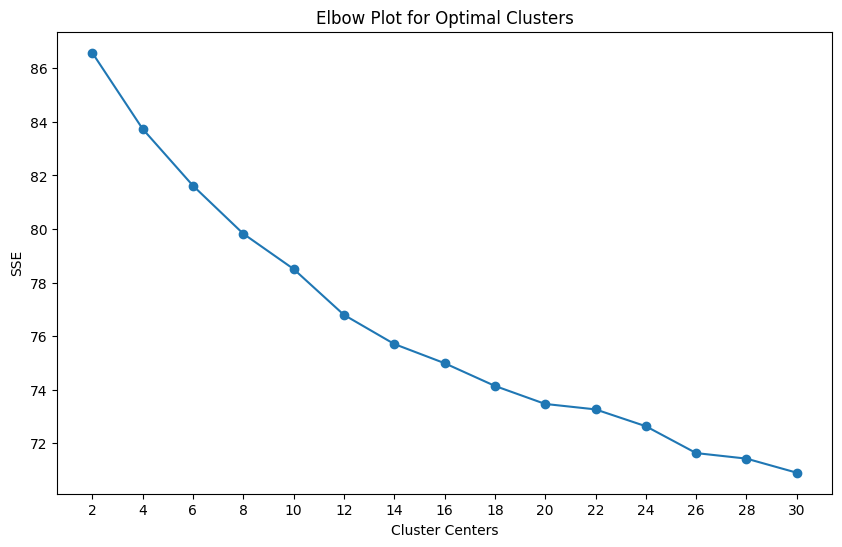

In [ ]:
# Function to find optimal clusters via Elbow Method
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k + 1, 2)
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print(f'Fit {k} clusters')
    plt.figure(figsize=(10, 6))
    plt.plot(iters, sse, marker='o')
    plt.xlabel('Cluster Centers')
    plt.xticks(iters)
    plt.ylabel('SSE')
    plt.title('Elbow Plot for Optimal Clusters')
    plt.show()

# Find elbow
cluster_num = 30
find_optimal_clusters(text, cluster_num)

# Perform final clustering
n_clusters = 10  # Adjust based on elbow plot
clusters = MiniBatchKMeans(n_clusters=n_clusters, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

# Add cluster labels to dataframe
df['Cluster'] = clusters

# Save to Excel
cluster_filename = "Cluster"
directory_path = '/content/drive/MyDrive/DL/'
cluster_file = f'{directory_path}/{cluster_filename}.xlsx'
df.drop(columns=['ID']).to_excel(cluster_file, index=False)


### 3.3 2D t-SNE Visualization

Visualize high-dimensional embeddings in 2D using PCA for dimensionality reduction followed by t-SNE, with points colored by cluster labels.

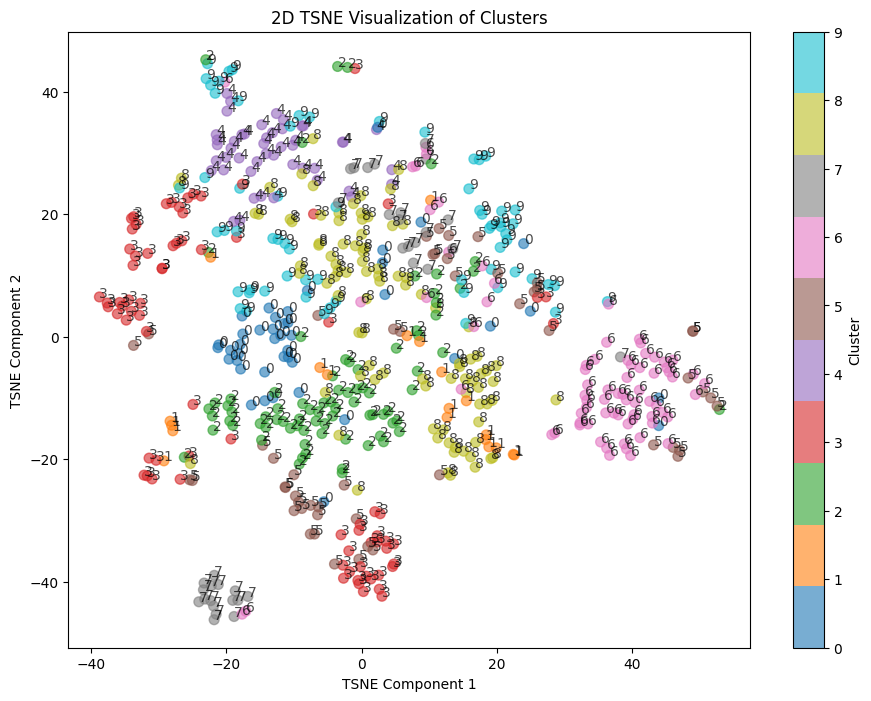

In [ ]:
# 2D TSNE Visualization
def plot_tsne_2d(data, labels):
    if isinstance(data, torch.Tensor):
        data_np = data.numpy()
    else:
        data_np = data

    if data_np.shape[1] < 2:
        raise ValueError("TSNE requires at least 2 features")

    sample_size = min(3000, data_np.shape[0])
    max_items = np.random.choice(range(data_np.shape[0]), size=sample_size, replace=False)
    n_components_pca = min(20, data_np.shape[1])

    # Apply PCA before TSNE for efficiency
    pca_result = PCA(n_components=n_components_pca).fit_transform(data_np[max_items, :])

    # Apply TSNE
    tsne = TSNE(perplexity=15, n_components=2, init='pca', max_iter=1000, learning_rate=100, random_state=23)
    tsne_result = tsne.fit_transform(pca_result)

    # Plot
    plt.figure(figsize=(11, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels[max_items], cmap='tab10', s=50, alpha=0.6)
    for i, idx in enumerate(max_items):
        plt.text(tsne_result[i, 0], tsne_result[i, 1], str(labels[idx]), fontsize=10, alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('2D TSNE Visualization of Clusters')
    plt.show()

# Visualize the clustering
plot_tsne_2d(text, clusters)


This bar Graph showing the number of control papers in each cluster

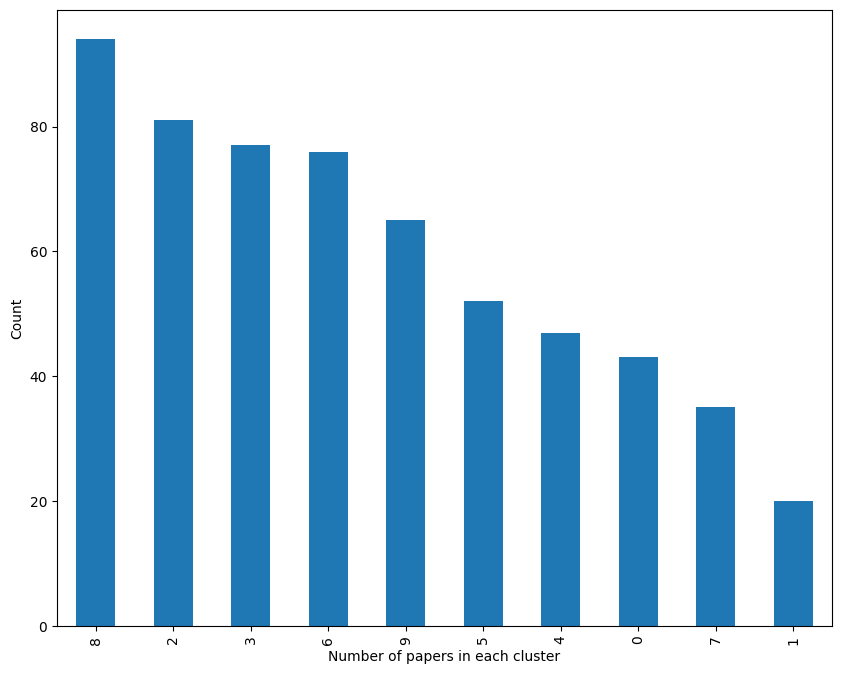

,Frequency
8,94
2,81
3,77
6,76
9,65
5,52
4,47
0,43
7,35
1,20


In [ ]:
#Display the number of papers classified into each cluster as a bar graph


import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

df = pd.read_excel(cluster_file, usecols=['Cluster'])
cluster_list = pd.to_numeric(df['Cluster'], errors='coerce').dropna().astype(int).tolist()

cluster_counts = pd.Series(cluster_list).value_counts()


plt.figure(figsize=(10, 8))
cluster_counts.plot(kind='bar')
plt.xlabel('Number of papers in each cluster')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

top30_clusters_df = cluster_counts.head(30).to_frame('Frequency')
display(HTML(top30_clusters_df.to_html()))


# 4. Evoluation

## 4.1 Keyword extraction From Each Cluster

Extracts and cleans keywords for each cluster, aggregates their frequencies,and returns the top N keywords per cluster. This helps summarize the main topics represented in each cluster for better interpretation of clustering results.



In [ ]:
from collections import Counter, defaultdict
import re
import pandas as pd

def get_top_keywords_per_cluster(df, top_n=10):
    cluster_keywords = {}

    for cluster in sorted(df['Cluster'].unique()):
        keywords_series = df[df['Cluster'] == cluster]['Keywords'].dropna()

        all_keywords = []
        for keywords in keywords_series:
            if isinstance(keywords, str):
                # Standardize separators
                clean_string = re.sub(r'(\/ ?n ?|/n|/|\n|\t|\r)', ',', keywords)
                # Split by comma
                kws = [kw.strip() for kw in clean_string.split(',')]
                # Clean each keyword: remove leading 'N ' or 'n ' and remove standalone 'n' or 'N'
                cleaned_kws = []
                for kw in kws:
                    # Remove leading 'N ' or 'n ' if exists
                    kw_cleaned = re.sub(r'^[Nn]\s+', '', kw)
                    # Remove standalone 'n' or 'N' entries
                    if kw_cleaned and kw_cleaned.lower() != 'n':
                        cleaned_kws.append(kw_cleaned)
                all_keywords.extend(cleaned_kws)
            elif not pd.isna(keywords):
                print(f"Warning: Found non-string keyword in cluster {cluster}: {keywords}")

        # Merge duplicates ignoring case and sum counts
        merged_counts = defaultdict(int)
        original_casing = {}

        for kw in all_keywords:
            kw_clean = kw.strip()
            kw_lower = kw_clean.lower()
            merged_counts[kw_lower] += 1
            # Keep the first casing seen
            if kw_lower not in original_casing:
                original_casing[kw_lower] = kw_clean

        # Convert to list of (original_case_keyword, count)
        merged_list = [(original_casing[kw_lower], count) for kw_lower, count in merged_counts.items()]

        # Sort by count descending and pick top_n
        merged_list.sort(key=lambda x: x[1], reverse=True)
        top_keywords = merged_list[:top_n]

        cluster_keywords[cluster] = top_keywords

    return cluster_keywords

# Load your DataFrame
df = pd.read_excel(cluster_file, usecols=['Cluster', 'Keywords'])

# Get top keywords by cluster
top_keywords_by_cluster = get_top_keywords_per_cluster(df)

# Print result
for cluster, keywords in top_keywords_by_cluster.items():
    print(f"\nCluster {cluster}:")
    if keywords:
        print(", ".join([f"{kw} ({count})" for kw, count in keywords]))
    else:
        print("No keywords available in this cluster.")



Cluster 0:
virtual reality (23), dementia (9), mental health (8), elderly (4), mild cognitive impairment (4), vr (4), well-being (3), alzheimer's disease (3), cognitive remediation (3), older adults (3)

Cluster 1:
virtual reality (8), anxiety (3), surgery (3), anesthesia (2), preoperative anxiety (2), digital health (2), wearable devices (2), systematic review (2), pain < complications (1), child < age (1)

Cluster 2:
virtual reality (42), stroke (7), rehabilitation (7), neurorehabilitation (5), systematic review (4), vr (3), virtual reality exposure therapy (3), cognitive rehabilitation (3), multiple sclerosis (3), efficacy (2)

Cluster 3:
virtual reality (22), mental health (10), augmented reality (9), autism spectrum disorder (8), extended reality (7), mixed reality (6), intervention (4), metaverse (4), technology (3), mobile phone (3)

Cluster 4:
virtual reality (24), exposure therapy (15), anxiety (8), anxiety disorders (6), social anxiety disorder (6), specific phobia (5), phob

### Ploting Top 15 keyword from each cluster in Pai chart

Generates a pie chart visualizing the top 15 most frequent keywords across all clusters.

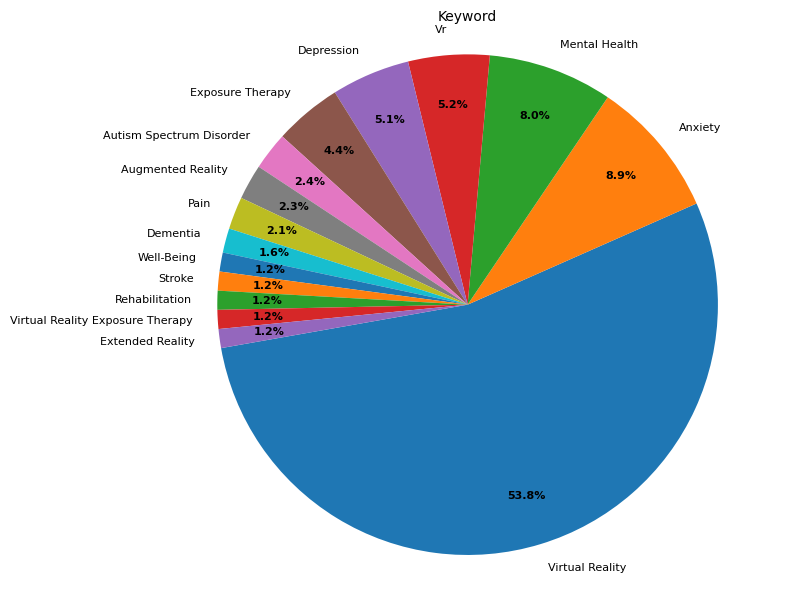

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import re

def plot_top_15_unique_keywords_pie(top_keywords_by_cluster):
    combined_counter = Counter()

    # Combine keywords from all clusters, merging duplicates ignoring case
    for cluster_keywords in top_keywords_by_cluster.values():
        for keyword, count in cluster_keywords:
            normalized_kw = keyword.lower()
            combined_counter[normalized_kw] += count

    # Get top 15 keywords by frequency
    top_15 = combined_counter.most_common(15)

    # For better labels, capitalize keywords nicely
    labels = [kw.title() for kw, _ in top_15]
    sizes = [count for _, count in top_15]

        # Explode small slices a bit to separate them visually (optional)
    explode = [0.08 if size < max(sizes)*0.10 else 0 for size in sizes]

    plt.figure(figsize=(8, 6))
    wedges, texts, autotexts = plt.pie(
        sizes, labels=labels, autopct='%1.1f%%', startangle=190, pctdistance=0.8,
        labeldistance=1.1
    )

    plt.setp(autotexts, size=8, weight="bold")
    plt.setp(texts, size=8)
    plt.title('Keyword', fontsize=10)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


# Load your data
df = pd.read_excel(cluster_file, usecols=['Cluster', 'Keywords'])

# Assuming get_top_keywords_per_cluster is already defined and returns the dictionary
top_keywords_by_cluster = get_top_keywords_per_cluster(df)

# Plot pie chart with top 15 unique keywords merged case insensitively
plot_top_15_unique_keywords_pie(top_keywords_by_cluster)


### 4.2 Cluster Summarization Using T5 (or BART)

Install the Libreary

In [ ]:
pip install transformers sentencepiece

Import the Librery

In [ ]:
from transformers import pipeline
import pandas as pd
from collections import defaultdict


Cluster-wise Abstract Summarization with T5 Model

- Generates automatic summaries of abstracts for each cluster using a pre-trained T5 summarization model.
- Groups abstracts by cluster, concatenates them, and produces a concise summary for each group.
- The summaries are added to the DataFrame and saved to an updated Excel file.



In [ ]:
# Load the clustered DataFrame
df = pd.read_excel('/content/drive/MyDrive/DL/Cluster.xlsx')
df['Clean Abstract'] = df['Clean Abstract'].fillna("")

# Initialize summarizer (you can use 'facebook/bart-large-cnn' as an alternative)
summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small", framework="pt")

# Group abstracts by cluster
cluster_texts = defaultdict(list)
for _, row in df.iterrows():
    cluster_texts[row['Cluster']].append(row['Clean Abstract'])

# Combine all abstracts per cluster into one big string
cluster_summaries = {}
for cluster_id, abstracts in cluster_texts.items():
    full_text = " ".join(abstracts)

    # Limit text size (transformers max input ~512-1024 tokens)
    full_text = full_text[:3000]  # Adjust if needed

    # Add prompt for T5
    input_text = "summarize: " + full_text

    try:
        summary = summarizer(input_text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']
    except Exception as e:
        summary = f"Failed to summarize cluster {cluster_id}: {str(e)}"

    cluster_summaries[cluster_id] = summary

# Print summaries
print(" Cluster Summaries:")
for cluster_id in sorted(cluster_summaries):
    print(f"\nCluster {cluster_id} Summary:\n{cluster_summaries[cluster_id]}")

# Optional: Add summary column back to DataFrame
df['Cluster Summary'] = df['Cluster'].map(cluster_summaries)

# Save to file
output_path = '/content/drive/MyDrive/DL/Cluster.xlsx'
df.to_excel(output_path, index=False)
print(f"\n Saved file with cluster summaries to: {output_path}")


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(

 Cluster Summaries:

Cluster 0 Summary:
vr based geriatric mental health interventions have grown rapidly since especially the number of interventions that promote wellbeing the function oriented interventions used active interactions with varied devices entertainment oriented interaction was primarily passive seldomly using hand controllers for moving activities .

Cluster 1 Summary:
physicians need alternatives to opioid drugs could manipulating the microbiome or virtual reality experiences have a role in easing pain with the ongoing opioid crisis . the aim of this review is to describe the use of vr and its effect on pain related outcome measures compared to routine care in various types of surgical procedures severe postoperative pain is associated with an increased risk of medical complications .

Cluster 2 Summary:
vr immersion can facilitate the delivery of health interventions by isolating participants from distractors and stressors in a therapeutic environment . new evidence s

### 4.3 Rank Papers by Similarity & Citations per Cluster

Normalize Similarity and Citation Metrics, Compute Combined Scores, and Rank Papers per Cluster



In [ ]:
import pandas as pd

# Load clustered DataFrame (with 'Cluster', 'Citations', and 'Similarity' columns)
df = pd.read_excel('/content/drive/MyDrive/DL/Cluster.xlsx')

# Handle missing values
df['Citations'] = pd.to_numeric(df['Citations'], errors='coerce').fillna(0)
df['Similarity'] = pd.to_numeric(df['Similarity'], errors='coerce').fillna(0)

# Normalize both metrics for fair ranking (scale between 0 and 1)
df['Citations_Norm'] = df['Citations'] / df['Citations'].max()
df['Similarity_Norm'] = df['Similarity'] / df['Similarity'].max()

# Combine both metrics: weighted average (adjust weights as needed)
df['CombinedScore'] = (0.6 * df['Similarity_Norm']) + (0.4 * df['Citations_Norm'])

# Rank within each cluster by CombinedScore (higher = better)
df['Cluster Rank'] = df.groupby('Cluster')['CombinedScore']\
                       .rank(method='dense', ascending=False).astype(int)

# Sort the whole DataFrame by cluster and rank
df_sorted = df.sort_values(by=['Cluster', 'Cluster Rank'])

# Display sample
print(df_sorted[['Cluster', 'Cluster Rank', 'Title', 'Citations', 'Similarity']].head(20))

# Save to Excel
output_path = '/content/drive/MyDrive/DL/Cluster.xlsx'
df_sorted.to_excel(output_path, index=False)
print(f"\n Ranked results saved to: {output_path}")

     Cluster  Cluster Rank                                              Title  \
335        0             1  Effects of a dual intervention (motor and virt...   
294        0             2  Effect of immersive virtual reality-based cogn...   
139        0             3  Virtual reality-based training may improve vis...   
585        0             4  A Change of Scenery: Transformative Insights f...   
18         0             5  Virtual Reality Mental Health Interventions in...   
25         0             6  Use of Virtual Reality and Augmented Reality T...   
36         0             7  Fully Immersive Virtual Reality Using 360° Vid...   
309        0             8  My virtual escape from patient life: a feasibi...   
44         0             9  Efficacy of virtual reality technology interve...   
334        0            10  Do Virtual Reality Relaxation Experiences Alle...   
51         0            11  Finding Peace in Pixels: Exploring the Therape...   
65         0            12  

### 4.4 Publication Count by Year

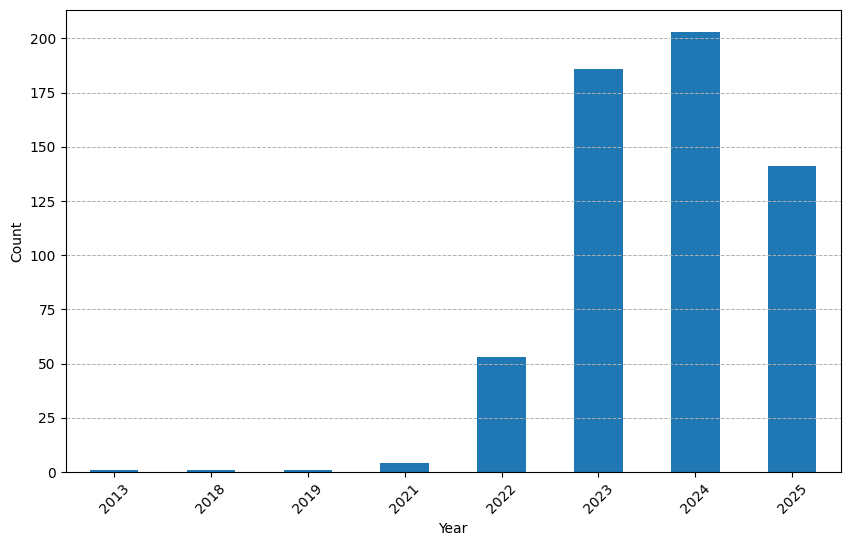

,Count
Year,
2013,1
2018,1
2019,1
2021,4
2022,53
2023,186
2024,203
2025,141


In [ ]:
df = pd.read_excel(cluster_file, usecols=['Year'])

df['Year'] = pd.to_datetime(df['Year'], format='%Y-%m-%d').dt.year

year_counts = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()

pd.set_option('display.max_colwidth', 50)
year_df = year_counts.head(11).to_frame('Count')

display(HTML(year_df.to_html(escape=False)))

### 4.5 Number of papers fetched from each database.



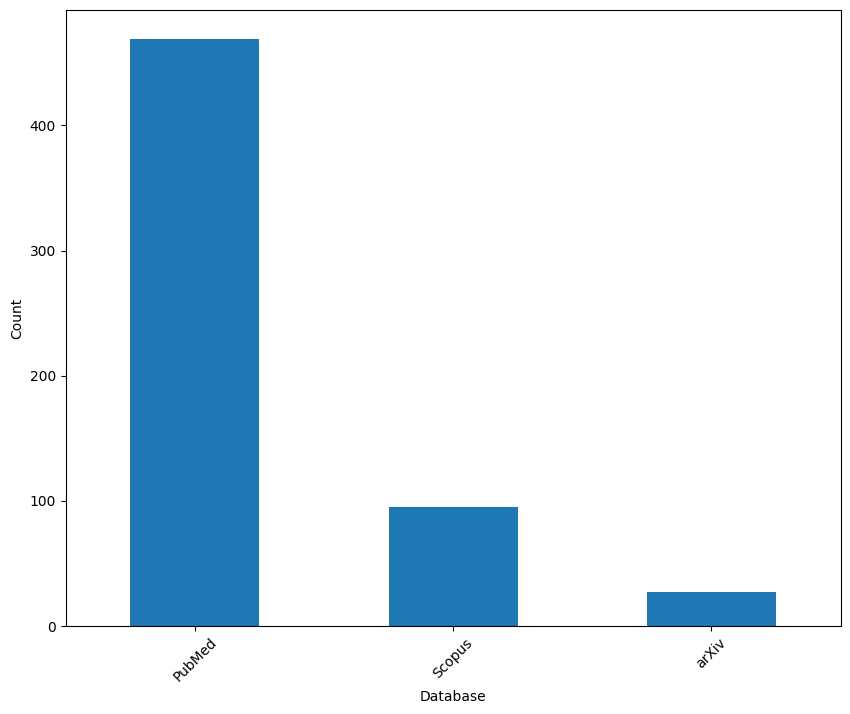

,Count
PubMed,469
Scopus,95
arXiv,27


In [ ]:
df = pd.read_excel(cluster_file, usecols=['Databases'])
database_list = df['Databases'].dropna().apply(lambda x: x.split('/')).tolist()

flat_database_list = [item.strip() for sublist in database_list for item in sublist]

database_counts = pd.Series(flat_database_list).value_counts()

plt.figure(figsize=(10, 8))
database_counts.plot(kind='bar')
plt.xlabel('Database')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

database_counts.head()

pd.set_option('display.max_colwidth', 50)
database_df = database_counts.head().to_frame('Count')

display(HTML(database_df.to_html(escape=False)))

### 4.6 Distribution of Papers Across Journals



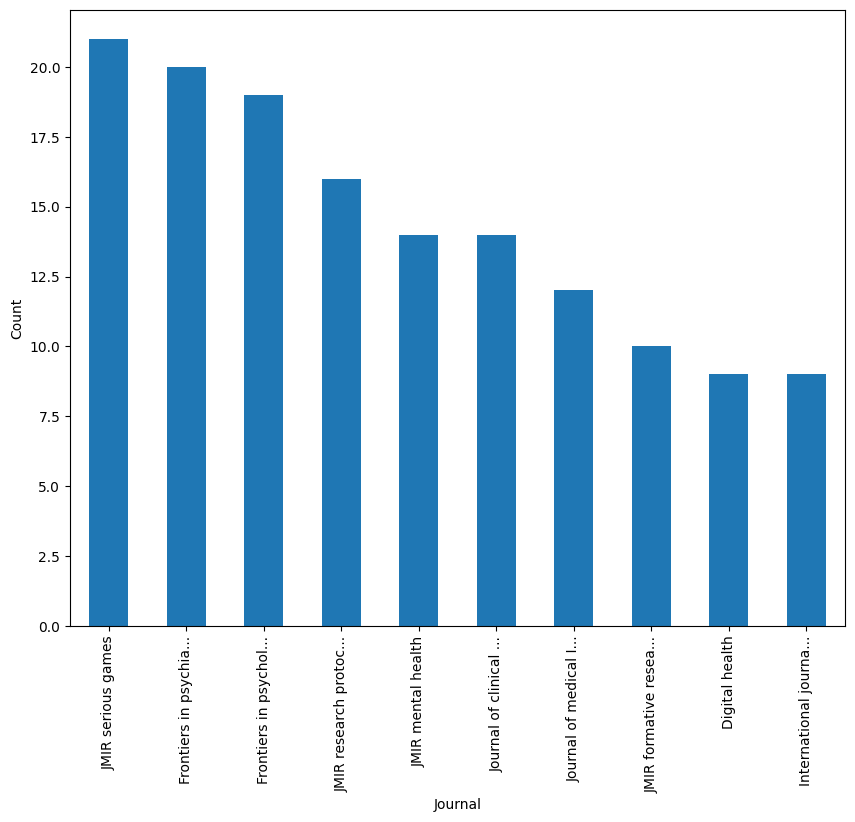

,Count
JMIR serious games,21
Frontiers in psychiatry,20
Frontiers in psychology,19
JMIR research protocols,16
JMIR mental health,14
Journal of clinical medicine,14
Journal of medical Internet research,12
JMIR formative research,10
Digital health,9
International journal of environmental research and public health,9


In [ ]:
df = pd.read_excel(cluster_file, usecols=['Journal'])
journal_list = df['Journal'].dropna().apply(lambda x: x.split('/')).tolist()

flat_journal_list = [item.strip() for sublist in journal_list for item in sublist]

journal_counts = pd.Series(flat_journal_list).value_counts()
top10_journals = journal_counts.head(10)

def abbreviate_journal_name(name, max_length=20):
    if len(name) > max_length:
        return name[:max_length] + "..."
    else:
        return name

abbreviated_journals = top10_journals.index.map(lambda x: abbreviate_journal_name(x))

plt.figure(figsize=(10, 8))
top10_journals.plot(kind='bar')
plt.xlabel('Journal')
plt.ylabel('Count')
plt.xticks(range(len(abbreviated_journals)), abbreviated_journals, rotation=90)
plt.show()

pd.set_option('display.max_colwidth', 50)
top30_journals_df = journal_counts.head(30).to_frame('Count')

display(HTML(top30_journals_df.to_html(escape=False)))